In [1]:
from pandas_datareader import data as pdr
from yahoo_fin import stock_info as si
import yfinance as yf
import pandas as pd
import datetime
import time
import talib
from talib import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost as xgb
import math
import numpy as np
from sklearn.decomposition import PCA
import pickle
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'
yf.pdr_override()

In [2]:
from LSSVMRegression import LSSVMRegression

In [3]:
def add_indicators():
        
    R_S_I = RSI(df['Adj Close'], timeperiod=slow)
    E_M_A = EMA(df['Adj Close'], timeperiod=fast)
    macd, macdsig, macdhist = MACD(df['Adj Close'], fastperiod=fast, slowperiod=slow, signalperiod=really_fast)
    mfi = MFI(df['High'], df['Low'], df['Adj Close'],df['Volume'],timeperiod=fast)
    slowk, slowd = STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=fast, slowk_period=slow, slowk_matype=0, slowd_period=slow, slowd_matype=0)
    
    #
    #
    #
    
    df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd
    
    
    
    ####
    
    

    #76 vars

    #are_all_zero = (test_TA == 0).all()
    #true if all values are 0
    #false if contain a non 0'''

    df.drop(['Close'], axis =1, inplace = True)

    

In [4]:
def add_lag(num_lag_cols, this_df):
    
    tic = time.perf_counter()
    
    '''df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd'''
    
    lag_cols = ['open',
                 'high',
                 'low',
                 'adj_close',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd']

    shift_range = [x+1 for x in range(num_lag_cols)]

    for shift in shift_range:
        train_shift = this_df[merging_keys + lag_cols].copy()

        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift

        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        this_df = pd.merge(this_df, train_shift, on=merging_keys, how='left') #.fillna(0)

    del train_shift
    
    toc = time.perf_counter()

    tic_toc = (toc - tic) / 60

    print(f"completed lagging in {tic_toc:0.4f} min")
    

    return this_df

In [5]:
def add_scale(num_interval_lag):

    cols_to_scale = ['open',#
                     'high',#
                     'low',#
                     'adj_close',#
                     'volume',#
                     'ema',#
                     'rsi',#
                     'macd',#
                     'macdsig',#
                     'macdhist',#
                     'mfi',#
                     'slowk',#
                     'slowd']#
                    

    for i in range(1,num_interval_lag+1):
        cols_to_scale.append("ema_lag_"+str(i))
        cols_to_scale.append("slowk_lag_"+str(i))
        cols_to_scale.append("slowd_lag_"+str(i))
        cols_to_scale.append("rsi_lag_"+str(i))

        cols_to_scale.append("volume_lag_"+str(i))

        cols_to_scale.append("adj_close_lag_"+str(i))
        
        cols_to_scale.append("open_lag_"+str(i))
        cols_to_scale.append("high_lag_"+str(i))
        cols_to_scale.append("low_lag_"+str(i))

        cols_to_scale.append("macd_lag_"+str(i))
        cols_to_scale.append("macdsig_lag_"+str(i))
        cols_to_scale.append("macdhist_lag_"+str(i))

        cols_to_scale.append("mfi_lag_"+str(i))
      
    return cols_to_scale

In [6]:
stock = 'HON'

start_date = datetime.datetime.now() - datetime.timedelta(days=59)

end_date = datetime.datetime.now()

df = pdr.get_data_yahoo(stock, start=start_date, end=end_date, interval = "2m", prepost = True)

#df = pdr.get_data_yahoo(stock, period = "max", interval = "1d", prepost = True)

#df.index = df.index.tz_localize(None)

'''#2 min ticker
# 30 intervals = 1 hour << OLD
# 195 intervals = trading day'''
                                            # there are more intervals that we can use / change
really_fast = 30
fast = 60
slow = 90

add_indicators()

# Convert Date column to datetime
df.reset_index(level=0, inplace=True)

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

df['order_day'] = [x for x in list(range(len(df)))]
# merging_keys


# Get difference between high and low of each day

[*********************100%***********************]  1 of 1 completed


In [7]:
col_list = df.columns.to_list()
col_list.remove('datetime')

In [8]:
col_list

['open',
 'high',
 'low',
 'adj_close',
 'volume',
 'ema',
 'rsi',
 'macd',
 'macdsig',
 'macdhist',
 'mfi',
 'slowk',
 'slowd',
 'order_day']

In [9]:
merging_keys = ['order_day']

num_interval_lag = 30

df = add_lag(num_interval_lag, df)

#df['adj_close'] = df['adj_close'].shift(30)

completed lagging in 0.0185 min


In [10]:
print(df.shape)

(7472, 405)


In [11]:
print(df.head(40))

                    datetime        open        high         low   adj_close  \
0  2021-01-13 19:20:00-05:00  207.020000  207.020000  207.020000  207.020000   
1  2021-01-13 19:32:00-05:00  207.020000  207.020000  207.020000  207.020000   
2  2021-01-13 19:36:00-05:00  207.030000  207.030000  207.030000  207.030000   
3  2021-01-13 19:44:00-05:00  207.030000  207.030000  207.030000  207.030000   
4  2021-01-14 05:52:00-05:00  207.250000  207.250000  207.250000  207.250000   
5  2021-01-14 07:00:00-05:00  207.000000  207.000000  207.000000  207.000000   
6  2021-01-14 07:44:00-05:00  207.230000  207.230000  207.060000  207.060000   
7  2021-01-14 08:06:00-05:00  208.990000  208.990000  208.990000  208.990000   
8  2021-01-14 08:16:00-05:00  208.990000  208.990000  207.030000  207.250000   
9  2021-01-14 08:18:00-05:00  207.560000  207.560000  207.550000  207.550000   
10 2021-01-14 08:20:00-05:00  207.560000  207.560000  207.560000  207.560000   
11 2021-01-14 08:28:00-05:00  207.230000

In [12]:
window_size = 30

df['adj_close'] = df['adj_close'].shift(-window_size)



In [13]:
cols_to_rem = ['open',
                 'high',
                 'low',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd',
                 'order_day']

In [14]:
close_vals_list = df['adj_close']

In [15]:
df.drop(cols_to_rem, axis = 1, inplace = True)

In [16]:
print(df.tail(40))

                      datetime   adj_close  open_lag_1  high_lag_1  \
7432 2021-03-01 07:28:00-05:00  206.949997  205.000000  205.000000   
7433 2021-03-01 07:50:00-05:00  206.880005  204.010000  204.010000   
7434 2021-03-01 07:58:00-05:00  206.820007  204.100000  204.100000   
7435 2021-03-01 08:00:00-05:00  206.630005  204.100000  204.100000   
7436 2021-03-01 08:26:00-05:00  206.490005  202.560000  205.500000   
7437 2021-03-01 08:38:00-05:00  206.710007  204.000000  204.000000   
7438 2021-03-01 08:40:00-05:00  207.020004  204.500000  204.500000   
7439 2021-03-01 08:42:00-05:00  207.240005  204.500000  204.500000   
7440 2021-03-01 08:48:00-05:00  207.050003  202.350000  202.350000   
7441 2021-03-01 08:52:00-05:00  207.070007  204.500000  204.500000   
7442 2021-03-01 08:58:00-05:00         NaN  205.000000  205.000000   
7443 2021-03-01 09:02:00-05:00         NaN  205.000000  205.000000   
7444 2021-03-01 09:04:00-05:00         NaN  204.500000  205.000000   
7445 2021-03-01 09:0

In [17]:


#close_vals_list = df['adj_close']

df.fillna(0, inplace=True)

#df.fillna(0, inplace=True)

#BUY => 1, SELL => 0, HOLD => 2

num_test = int(.10*len(df))
num_train = len(df) - num_test

# Split into train, cv, and test
train = df[:num_train]
test = df[num_train:]

#print(test['datetime'].iloc[[-1]])
#print(test['test_labels'].iloc[[-1]])

train_close_vals = close_vals_list[:num_train]
test_close_vals = close_vals_list[num_train:]

#test_dates_list = test['date']
#BUY => 1, SELL => 0, HOLD => 2

In [18]:
test_dates_list = test['datetime']

In [19]:
train_dates_list = train['datetime']

In [20]:
test_adj_close_list = close_vals_list[num_train:]

In [21]:
cols_to_scale = add_scale(num_interval_lag)
#cols_to_scale.remove(cols_to_rem)

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak


In [22]:
for element in cols_to_rem:

    if element in cols_to_scale:

        cols_to_scale.remove(element)

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
#scaler = StandardScaler()

scaler = MinMaxScaler(feature_range=(-1,1))

scaler.fit(train[cols_to_scale])
train_scaled = scaler.transform(train[cols_to_scale])

# Convert the numpy array back into pandas dataframe

train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)

train_scaled = train_scaled[slow:]
train = train[slow:]

#scaling test dataset

#scaler_2 = StandardScaler()

scaler_2  = MinMaxScaler(feature_range=(-1,1))
scaler_2.fit(test[cols_to_scale])
test_scaled = scaler_2.transform(test[cols_to_scale])

# Convert the numpy array back into pandas dataframe

test_scaled = pd.DataFrame(test_scaled, columns=cols_to_scale)

features = cols_to_scale

In [25]:
features

['adj_close',
 'ema_lag_1',
 'slowk_lag_1',
 'slowd_lag_1',
 'rsi_lag_1',
 'volume_lag_1',
 'adj_close_lag_1',
 'open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'macd_lag_1',
 'macdsig_lag_1',
 'macdhist_lag_1',
 'mfi_lag_1',
 'ema_lag_2',
 'slowk_lag_2',
 'slowd_lag_2',
 'rsi_lag_2',
 'volume_lag_2',
 'adj_close_lag_2',
 'open_lag_2',
 'high_lag_2',
 'low_lag_2',
 'macd_lag_2',
 'macdsig_lag_2',
 'macdhist_lag_2',
 'mfi_lag_2',
 'ema_lag_3',
 'slowk_lag_3',
 'slowd_lag_3',
 'rsi_lag_3',
 'volume_lag_3',
 'adj_close_lag_3',
 'open_lag_3',
 'high_lag_3',
 'low_lag_3',
 'macd_lag_3',
 'macdsig_lag_3',
 'macdhist_lag_3',
 'mfi_lag_3',
 'ema_lag_4',
 'slowk_lag_4',
 'slowd_lag_4',
 'rsi_lag_4',
 'volume_lag_4',
 'adj_close_lag_4',
 'open_lag_4',
 'high_lag_4',
 'low_lag_4',
 'macd_lag_4',
 'macdsig_lag_4',
 'macdhist_lag_4',
 'mfi_lag_4',
 'ema_lag_5',
 'slowk_lag_5',
 'slowd_lag_5',
 'rsi_lag_5',
 'volume_lag_5',
 'adj_close_lag_5',
 'open_lag_5',
 'high_lag_5',
 'low_lag_5',
 'macd_lag_5',
 '

In [26]:
features.remove('adj_close')

In [27]:
print('adj_close' in features)

False


In [28]:
print('adj_close' in train_scaled.columns)

True


In [29]:
#features.remove(target)

# Split into X and y
'''X_train_scaled = train_scaled[features]
y_train_scaled = train['labels']

X_test_scaled = test_scaled[features]
y_test_scaled = test['labels']'''

X_train = train_scaled[features]
y_train = train_scaled['adj_close']

X_test = test_scaled[features]
y_test = test_scaled['adj_close']

In [30]:
import pyswarms as ps

from sklearn.metrics import mean_squared_error

In [35]:
def fitness_function(position):
    
    #print(position)
    
    #svrRegressor = SVR(kernel='rbf', gamma = position[0].all(), C = position[1].all() )
    
    clfrbf=LSSVMRegression(
        gamma=position[0].all(),       #set the gamma-hyper parameter equal to 1
        kernel='rbf', #use the linear kernel
        sigma=position[1].all(),
            )
    
    clfrbf.fit(X_train, y_train)
    
    y_train_pred = clfrbf.predict(X_train)
    
    y_test_pred = clfrbf.predict(X_test)
    
    mse_test =mean_squared_error(y_test, y_test_pred)
    
    rmse_test = math.sqrt(mse_test)
    
    print('Optimizing the Parameters ..... C = {c}, Gamma={gamma}'.format(c=position[1], gamma=position[0]))
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    rmse_train = math.sqrt(mse_train)
    
    #list(range(mse_f_train,rmse_f_train))
    retVal= rmse_test #Return a vector instead of single value. you can use the rmse_test and ignore rmse_train
    
    return retVal

In [36]:
lb = [10, 0.0001]
ub = [1000,0.1]
#mb = [100, 0.001]
bounds = (lb,ub)

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=2,options=options, bounds = bounds)
gamma_opt, C_opt = optimizer.optimize(fitness_function, iters=50)

2021-03-01 09:35:09,316 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████|50/50, best_cost=1.01
2021-03-01 11:48:51,527 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0108298213775981, best pos: [7.19128262e+02 9.83550239e-02]


In [37]:
print(gamma_opt)
print(C_opt)

1.0108298213775981
[7.19128262e+02 9.83550239e-02]


NameError: name 'clfrbf' is not defined

In [40]:
clfrbf=LSSVMRegression(
        gamma=C_opt[0],       #set the gamma-hyper parameter equal to 1
        kernel='rbf', #use the linear kernel
        sigma=C_opt[1]
            )

In [41]:
clfrbf.fit(X_train, y_train)

In [42]:
y_hat = clfrbf.predict(X_test)

In [43]:
test_scaled['adj_close'] = y_hat

inv_scaler = scaler_2.inverse_transform(test_scaled)

y_hat_descaled = pd.DataFrame(inv_scaler, columns = test_scaled.columns)

In [44]:
y_hat

array([-0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01083752,
       -0.01083752, -0.01083752, -0.01083752, -0.01083752, -0.01

<IPython.core.display.Javascript object>


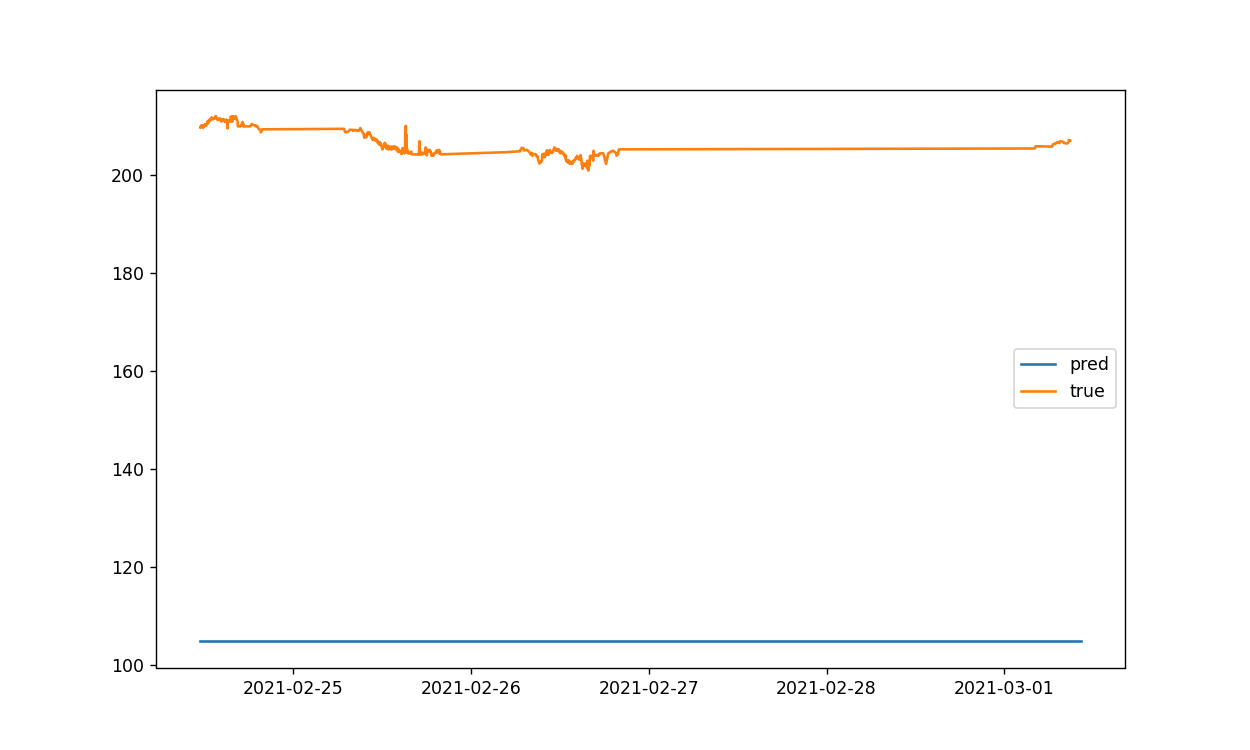

<function matplotlib.pyplot.show(block=None)>

In [45]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(test_dates_list, y_hat_descaled['adj_close'])
plt.plot(test_dates_list, test_adj_close_list)
plt.legend(['pred','true'])
plt.show

In [46]:
y_hat = clfrbf.predict(X_train)

In [47]:
train_scaled['adj_close'] = y_hat

inv_scaler = scaler.inverse_transform(train_scaled)

y_hat_descaled = pd.DataFrame(inv_scaler, columns = train_scaled.columns)

<IPython.core.display.Javascript object>


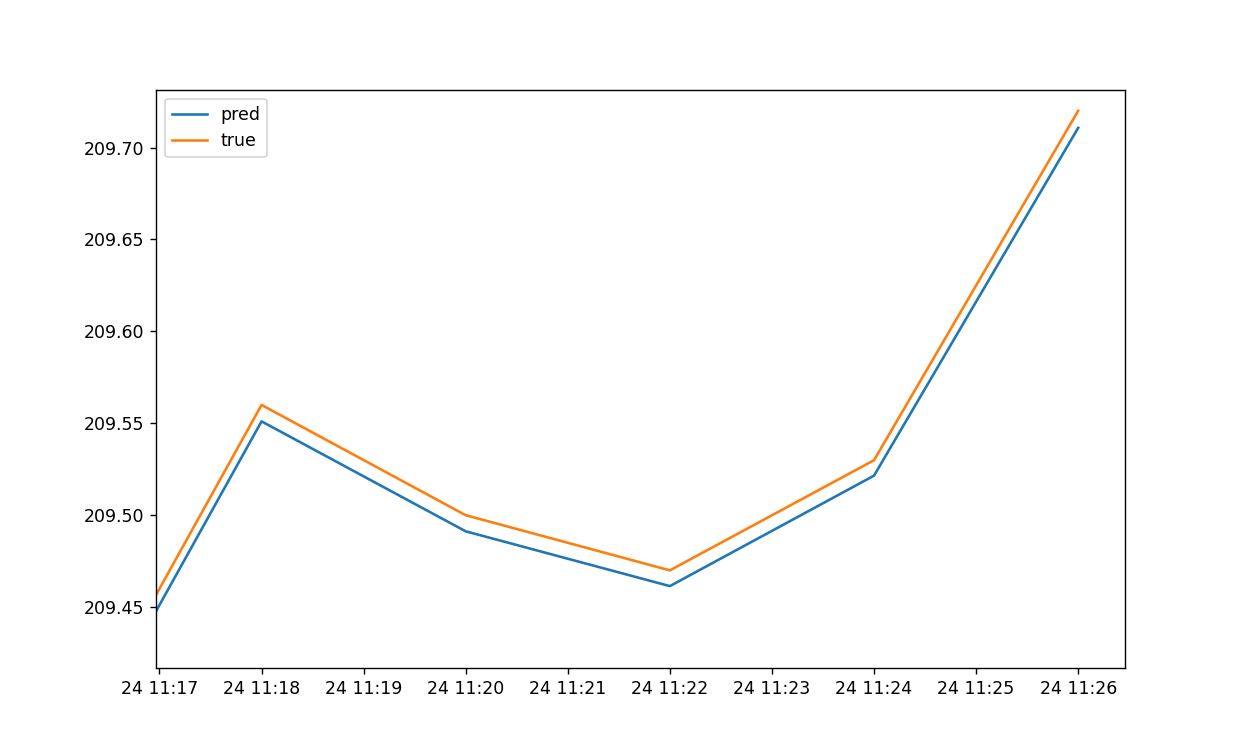

<function matplotlib.pyplot.show(block=None)>

In [48]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(train_dates_list[slow:], y_hat_descaled['adj_close'])
plt.plot(train_dates_list[slow:], train_close_vals[slow:])
plt.legend(['pred','true'])
plt.show